In [1]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


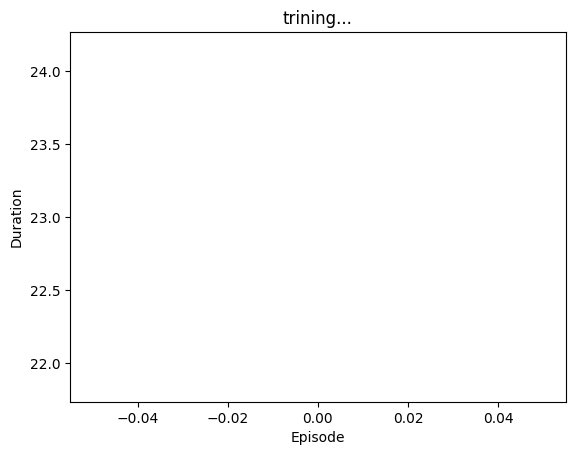

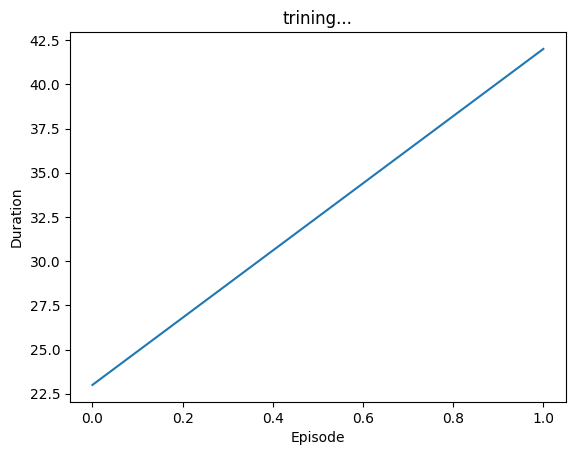

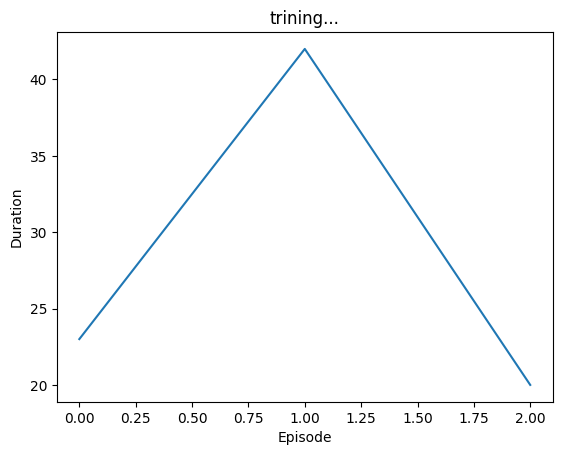

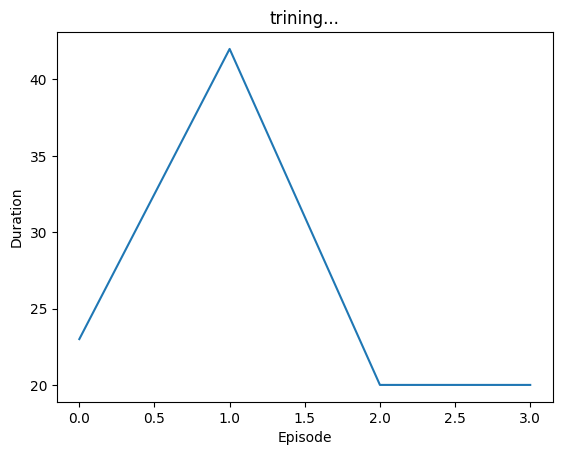

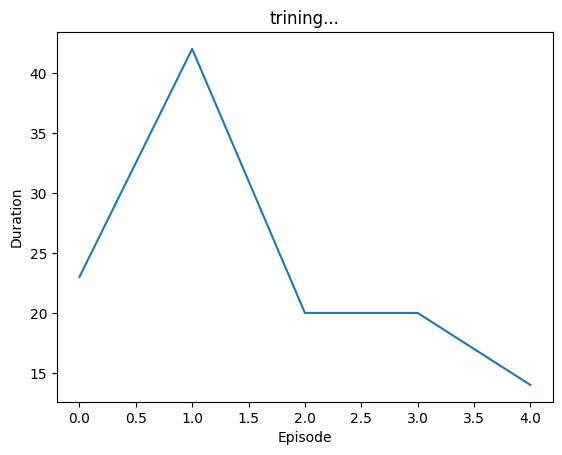

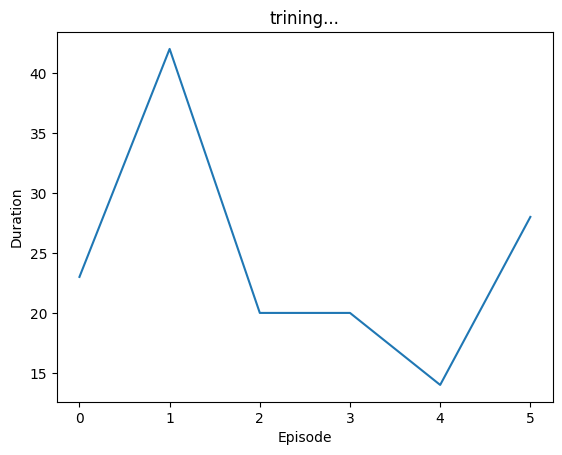

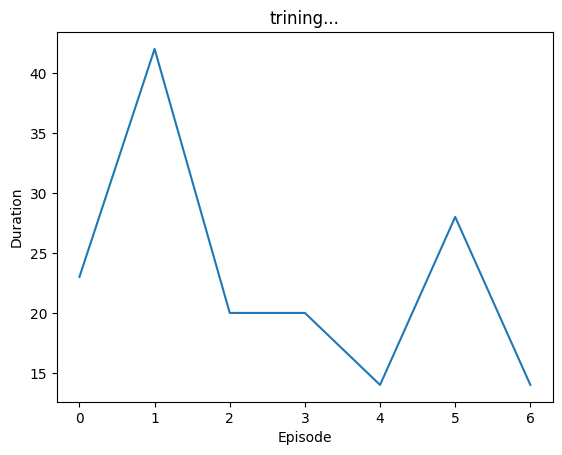

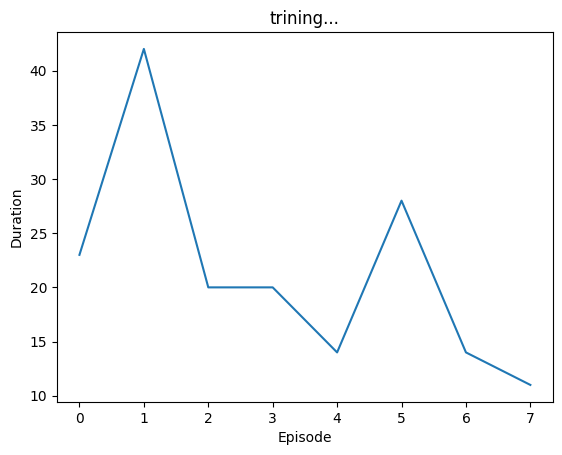

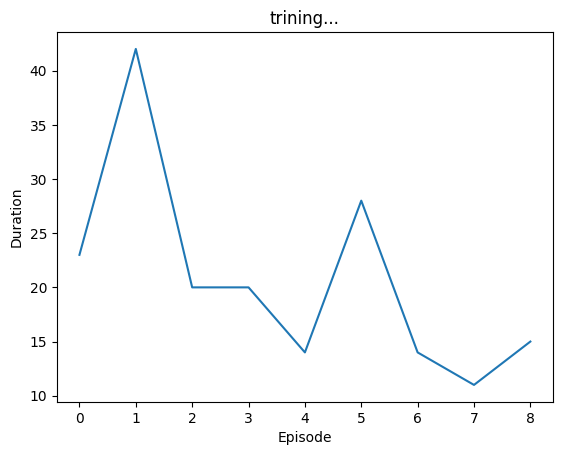

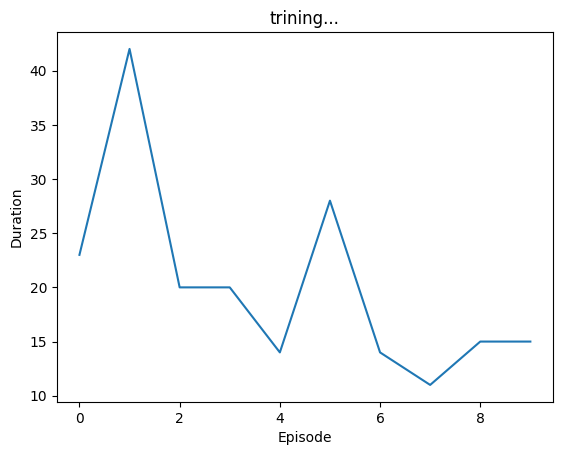

Episode data:  [(1, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (0, 1.0), (0, 1.0)]


In [5]:

# 名称环境
CONST_ENV_NAME = 'CartPole-v1'
# 使用GPU
CONST_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# CONST_DEVICE = torch.device("cpu")

# ReplayMemory元素定义
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# 实现ReplayMemory技术
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        '''保存数据到ReplayMemory'''
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        '''随机选取batch_size大小的样本'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# 基于卷积神经网络的DQN模型
class DQN_Model(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self._calculate_conv_output(h, w), 512)
        self.fc2 = nn.Linear(512, outputs)

    def _calculate_conv_output(self, h, w):
        # 计算卷积层输出大小的函数
        def conv2d_size_out(size, kernel_size=3, stride=1):
            return (size - (kernel_size - 1) - 1) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 8, 4), 4, 2), 3, 1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 8, 4), 4, 2), 3, 1)
        return convw * convh * 64

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        return self.fc2(x)

class DQN_Agent:
    def __init__(self, env, BATCH_SIZE=128, GAMMA=0.99, EPS_START=0.9, EPS_END=0.05, EPS_DECAY=1000, TAU=0.005, LR=1e-4):
        self.env = env
        self.n_actions = env.action_space.n
        state, _ = self.env.reset()
        init_screen = self.get_screen()
        _, _, screen_height, screen_width = init_screen.shape
        self.policy_net = DQN_Model(screen_height, screen_width, self.n_actions).to(CONST_DEVICE)
        self.target_net = DQN_Model(screen_height, screen_width, self.n_actions).to(CONST_DEVICE)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)
        self.steps_done = 0
        self.episode_durations = []
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.TAU = TAU

    def get_screen(self):
        # 从环境中获取当前状态
        screen = self.env.render()
        screen = torch.tensor(screen, dtype=torch.float32).permute(2, 0, 1)  # 调整通道顺序
        return screen.unsqueeze(0).to(CONST_DEVICE)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(-1. * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=CONST_DEVICE, dtype=torch.long)

    def plot_durations(self, show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('resoult')
        else:
            plt.clf()
            plt.title('trining...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        plt.pause(0.001)

    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=CONST_DEVICE, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.BATCH_SIZE, device=CONST_DEVICE)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def play_agent(self):
        env2 = gym.make(CONST_ENV_NAME, render_mode='human')
        state = env2.reset()[0]
        state = self.get_screen()
        done = False
        res = []
        while not done:
            action = self.select_action(state)
            action = action.item()
            observation, reward, terminated, truncated, _ = env2.step(action)
            env2.render()

            res.append((action, reward))

            if terminated:
                next_state = None
            else:
                next_state = self.get_screen()

            state = next_state
            if terminated or truncated:
                done = True
        
        print('Episode data: ', res)
        env2.close()

    def learn(self):
        num_episodes = 10 if torch.cuda.is_available() else 10
        for i_episode in range(num_episodes):
            self.env.reset()
            state = self.get_screen()
            for t in count():
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=CONST_DEVICE)

                done = terminated or truncated
                next_state = None if terminated else self.get_screen()
                self.memory.push(state, action, next_state, reward)

                state = next_state
                self.optimize_model()

                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key] * self.TAU + target_net_state_dict[key] * (1 - self.TAU)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    self.episode_durations.append(t + 1)
                    self.plot_durations()
                    break

def main():
    env = gym.make(CONST_ENV_NAME, render_mode='rgb_array')
    agent = DQN_Agent(env)
    agent.learn()
    agent.play_agent()

if __name__ == '__main__':
    main()
